# Examen Bimestre 2 

## Medical Cost Personal

### Integrantes:
• Nohelia Ludeña.

• David Morales.

In [46]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Modelado
# ==============================================================================
from ngboost import NGBRegressor
from ngboost import scores
from ngboost import distns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
import inspect
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/insurance.csv', sep=','); #Lectura del csv

In [3]:
data['sex'] = data['sex'].replace({'female': 1, 'male': 2})
data['smoker'] = data['smoker'].replace({'yes': 1, 'no': 2})
data['region'] = data['region'].replace({'southwest': 1, 'southeast': 2, 'northwest': 3, 'northeast': 4})

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,1,16884.92400
1,18,2,33.770,1,2,2,1725.55230
2,28,2,33.000,3,2,2,4449.46200
3,33,2,22.705,0,2,3,21984.47061
4,32,2,28.880,0,2,3,3866.85520


## Valores perdidos

In [38]:
# Importaciones
import os
import pandas as pd
import seaborn as sns
import missingno as msno 

<AxesSubplot:>

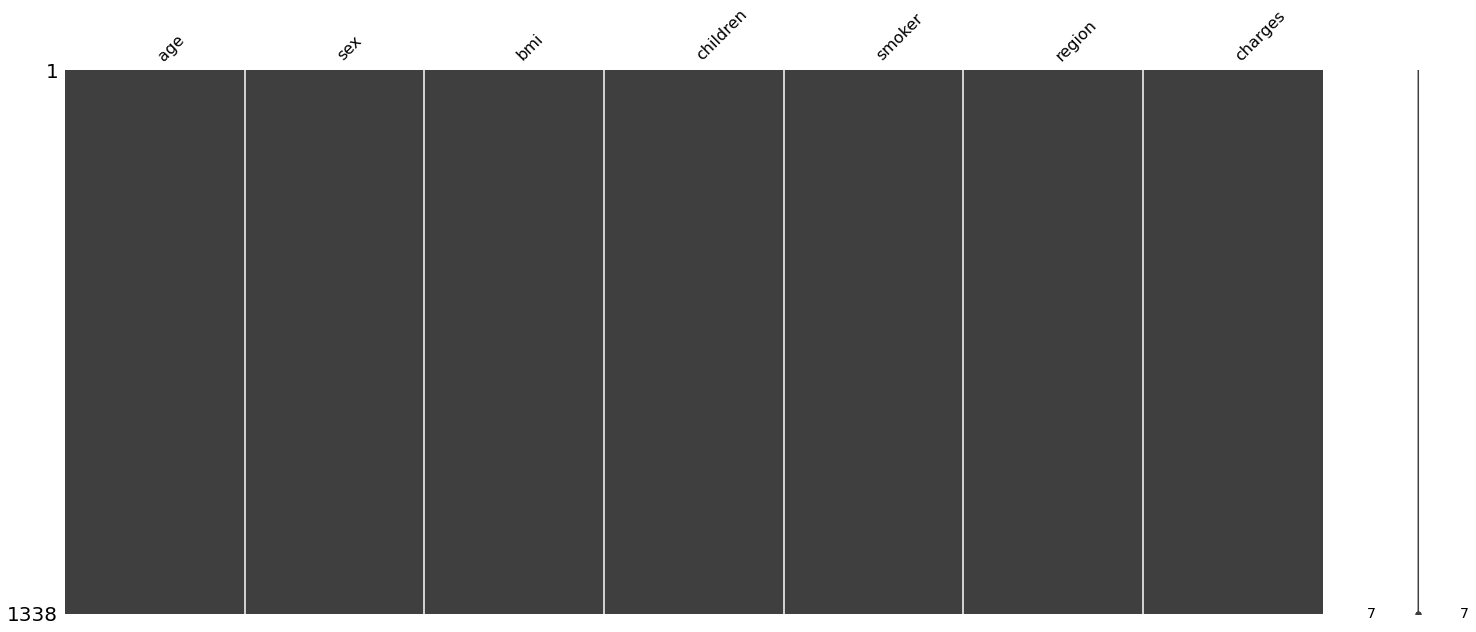

In [39]:
msno.matrix(data) 

<AxesSubplot:>

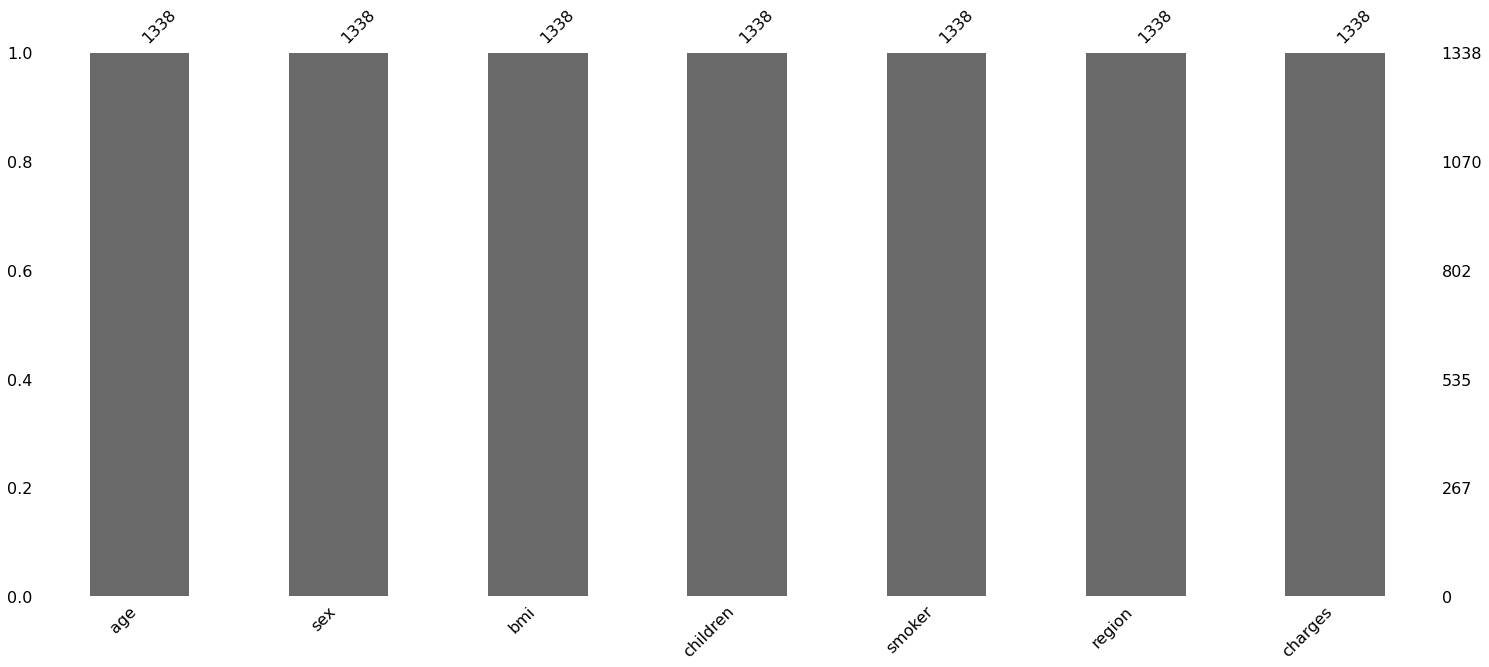

In [41]:
msno.bar(data)

## Gradient Boosting

Un modelo Gradient Boosting está formado por un conjunto de árboles de decisión individuales, entrenados de forma secuencial, de forma que cada nuevo árbol trata de mejorar los errores de los árboles anteriores. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Source: https://www.cienciadedatos.net/documentos/py09_gradient_boosting_python.html#AdaBoost

Muchos métodos predictivos generan modelos globales en los que una única ecuación se aplica a todo el espacio muestral. Cuando el caso de uso implica múltiples predictores, que interaccionan entre ellos de forma compleja y no lineal, es muy difícil encontrar un único modelo global que sea capaz de reflejar la relación entre las variables. Los métodos estadísticos y de machine learning basados en árboles engloban a un conjunto de técnicas supervisadas no paramétricas que consiguen segmentar el espacio de los predictores en regiones simples, dentro de las cuales es más sencillo manejar las interacciones. Es esta característica la que les proporciona gran parte de su potencial.

La mayoría de métodos de machine learning aplicados a problemas de regresión modelan el comportamiento de una variable respuesta  y  en función de uno o varios predictores  X , y generan predicciones de tipo "estimación puntual". Estás predicciones se corresponden el valor esperado de  y  dado un determinado valor de los predictores ( E[y|X] ).

## Dataset

El dataset contiene información sobre la edad (age) e índice de masa corporal (bmi) de personas de entre 18 y 60 años. El objetivo es entrenar un modelo capaz de predecir cuantiles del índice de masa corporal en función de la edad, ya que este es uno de los estándares empleados para detectar casos anómalos que pueden requerir gasto y atención médica.

In [61]:
data.info() # inspeccionar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null int64
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null int64
region      1338 non-null int64
charges     1338 non-null float64
dtypes: float64(2), int64(5)
memory usage: 73.2 KB


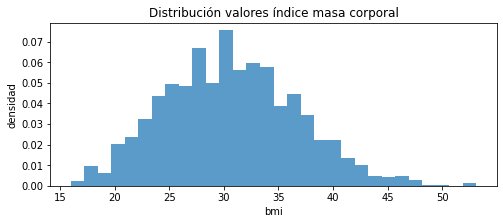

In [59]:
# Gráfico distribución
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 3))
ax.hist(data.bmi, bins=30, density=True, color='#3182bd', alpha=0.8)
ax.set_title('Distribución valores índice masa corporal')
ax.set_xlabel('bmi')
ax.set_ylabel('densidad');

### Selección distribución paramétrica

Los modelos NGBoost requieren que se especifique un tipo de distribución paramétrica, por lo que el primer paso es identificar cuál de las tres distribuciones disponibles en NGBoost (normal, lognormal y exponencial) se ajusta mejor a los datos.

Se procede a ajustar cada una de las distribuciones y se evalúan gráficamente superponiéndolas con el histograma. Puede encontrarse información detallada de cómo comparar distribuciones en Ajuste y selección de distribuciones con Python: https://www.cienciadedatos.net/documentos/pystats01-ajuste-distribuciones-python.html

In [118]:
data['age'].unique() # valores unicos de edad

array([19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 23, 56, 27, 52, 30, 34,
       59, 63, 55, 22, 26, 35, 24, 41, 38, 36, 21, 48, 40, 58, 53, 43, 64,
       20, 61, 44, 57, 29, 45, 54, 49, 47, 51, 42, 50, 39], dtype=int64)

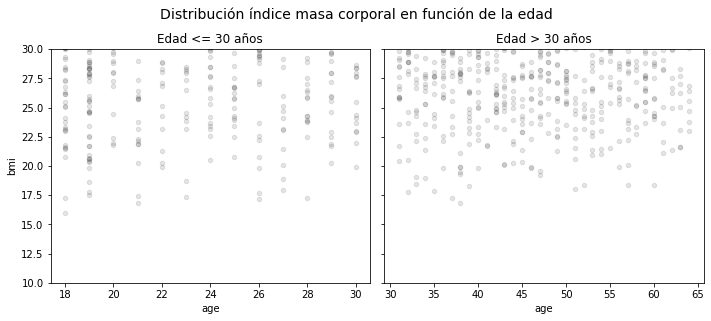

In [113]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4.5), sharey=True)

data[data.age <= 30].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'black',
    kind = "scatter",
    alpha = 0.1,
    ax   = axs[0]
)
axs[0].set_ylim([10, 30])
axs[0].set_title('Edad <= 30 años')

data[data.age > 30].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'black',
    kind = "scatter",
    alpha = 0.1,
    ax   = axs[1]
)
axs[1].set_title('Edad > 30 años')

fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Distribución índice masa corporal en función de la edad', fontsize = 14);

In [79]:
data['age']

0       19
1       18
2       28
3       33
4       32
        ..
1333    50
1334    18
1335    18
1336    21
1337    61
Name: age, Length: 1338, dtype: int64

In [66]:
def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función ajusta y superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend();
    
    return ax

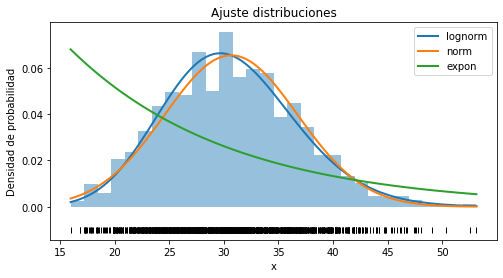

In [68]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_multiple_distribuciones(
    x=data.bmi.to_numpy(),
    nombre_distribuciones=['lognorm', 'norm', 'expon'],
    ax=ax
);

La representación gráfica muestra claras evidencias de que, entre las distribuciones disponibles, la lognormal es la que mejor se ajusta. Y la norm esta cercanamente ajustada al histograma.

### Modelo

A diferencia del ejemplo anterior, en este caso, se recurre a validación cruzada para identificar los hiperparámetros óptimos

In [71]:
X = data.age.to_numpy()
y = data.bmi.to_numpy()

# Grid de hiperparámetros
# ==============================================================================
b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)
b3 = DecisionTreeRegressor(criterion='friedman_mse')

param_grid = {
    'Base': [b1, b2],
    'n_estimators': [100, 500, 1000]
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator = NGBRegressor(
                        Dist    = distns.LogNormal,
                        Score   = scores.LogScore,
                        verbose = False
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0
       )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X.reshape(-1, 1), y = y)

In [81]:
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)


,param_Base,param_n_estimators,mean_test_score,std_test_score
0,DecisionTreeRegressor(criterion='friedman_mse'...,100,-6.087682,0.263946
1,DecisionTreeRegressor(criterion='friedman_mse'...,500,-6.128917,0.255115
3,DecisionTreeRegressor(criterion='friedman_mse'...,100,-6.131462,0.257520
2,DecisionTreeRegressor(criterion='friedman_mse'...,1000,-6.171720,0.254220
4,DecisionTreeRegressor(criterion='friedman_mse'...,500,-6.212624,0.254832
5,DecisionTreeRegressor(criterion='friedman_mse'...,1000,-6.232949,0.255255


In [82]:
# Mejores hiperparámetros
# ==============================================================================
print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'n_estimators': 100} : -6.0876820698983165 neg_root_mean_squared_error


In [83]:
# Mejor modelo encontrado
# ==============================================================================
modelo = grid.best_estimator_

Mediante los arboles de regresión, se puede observar que el mejor hiperparametro encontrado fue el árbol base ya que es que el tiene la menor media y por ende existe un menor margen de error


### Predicción intervalos

Una vez conocidos los parámetros de la distribución condicional, se pueden calcular los cuantiles del índice de masa corporal esperados para cada edad.

In [85]:
grid_X = np.linspace(start=min(data.age), stop=max(data.age), num=2000)
predicciones_dist = modelo.pred_dist(X=grid_X.reshape(-1, 1))
pred_cuantil_10 = [stats.lognorm.ppf(q=0.1, **dist.params) for dist in predicciones_dist]
pred_cuantil_90 = [stats.lognorm.ppf(q=0.9, **dist.params) for dist in predicciones_dist]
df_intervalos = pd.DataFrame({
                    'age': grid_X,
                    'pred_cuantil_10': pred_cuantil_10,
                    'pred_cuantil_90': pred_cuantil_90
                })

KeyError: 'pred_cuantil_10'

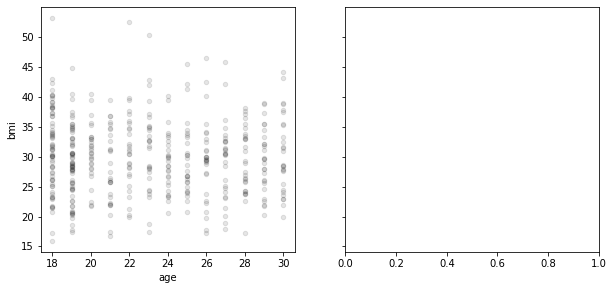

In [116]:
# Gráfico intervalo cuantílico 10%-90%
# ==============================================================================
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4.5), sharey=True)

data[data.age <= 30].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'black',
    kind = "scatter",
    alpha = 0.1,
    ax   = axs[0]
)

df_intervalos[df_intervalos.age <= 30].plot(
    x    = 'age',
    y    = 'pred_cuantil_10',
    c    = 'red',
    kind = "line",
    ax   = axs[0]
)

df_intervalos[df_intervalos.age <= 30].plot(
    x    = 'age',
    y    = 'pred_cuantil_90',
    c    = 'red',
    kind = "line",
    ax   = axs[0]
)

axs[0].set_ylim([10, 30])
axs[0].set_title('Edad <= 30 años')

data[data.age > 30].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'black',
    kind = "scatter",
    alpha = 0.1,
    ax   = axs[1]
)

df_intervalos[df_intervalos.age > 30].plot(
    x    = 'age',
    y    = 'pred_cuantil_10',
    c    = 'red',
    kind = "line",
    ax   = axs[1]
)

df_intervalos[df_intervalos.age > 30].plot(
    x    = 'age',
    y    = 'pred_cuantil_90',
    c    = 'red',
    kind = "line",
    ax   = axs[1]
)
axs[1].set_title('Edad > 30 años')
axs[1].get_legend().remove()

fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Distribución índice masa corporal en función de la edad', fontsize = 14);

### Cobertura

In [88]:
# Predicción intervalos para las observaciones disponibles
# ==============================================================================
predicciones_dist = modelo.pred_dist(X=X.reshape(-1, 1))
pred_cuantil_10 = [stats.lognorm.ppf(q=0.1, **dist.params) for dist in predicciones_dist]
pred_cuantil_90 = [stats.lognorm.ppf(q=0.9, **dist.params) for dist in predicciones_dist]

In [130]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where((y >= pred_cuantil_10) & (y <= pred_cuantil_90), True, False)
cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 80.56801195814649


Se han calculado los cuantiles 0.1 y 0.9, así que, el intervalo, tiene una confianza del 80%. Si el intervalo predicho es correcto, aproximadamente el 80% de las observaciones estarán dentro. Entonces las observaciones serán correctas ya que se aproxima ampliamente al porcentaje de intervalo


### Anomalías (outliers)

In [91]:
# Predicción intervalos del 98% para las observaciones disponibles
# ==============================================================================
X = data.age.to_numpy()
y = data.bmi.to_numpy()

predicciones_dist = modelo.pred_dist(X=X.reshape(-1, 1))
pred_cuantil_01 = [stats.lognorm.ppf(q=0.01, **dist.params) for dist in predicciones_dist]
pred_cuantil_99 = [stats.lognorm.ppf(q=0.99, **dist.params) for dist in predicciones_dist]
dentro_intervalo = np.where((y >= pred_cuantil_01) & (y <= pred_cuantil_99), True, False)

In [92]:
df_intervalos = pd.DataFrame({
                    'age': X,
                    'bmi': y,
                    'pred_cuantil_01': pred_cuantil_01,
                    'pred_cuantil_99': pred_cuantil_99,
                    'dentro_intervalo': dentro_intervalo
                })

In [93]:
df_intervalos.head()

,age,bmi,pred_cuantil_01,pred_cuantil_99,dentro_intervalo
0,19,27.900,17.991923,47.429391,True
1,18,33.770,18.311377,49.651195,True
2,28,33.000,18.292152,47.063303,True
3,33,22.705,18.587703,47.880717,True
4,32,28.880,18.587703,47.880717,True


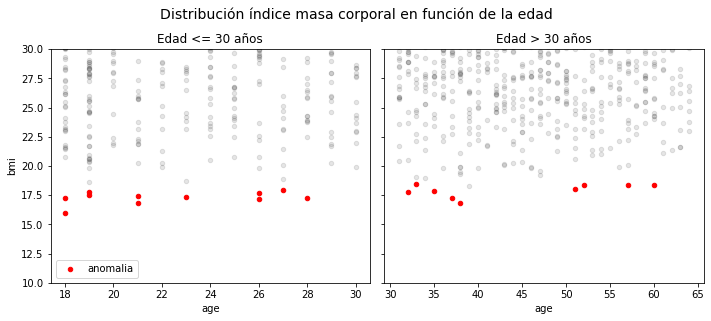

In [117]:
# Gráfico anomalías
# ==============================================================================
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4.5), sharey=True)

df_intervalos[df_intervalos.age <= 30].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'black',
    kind = "scatter",
    alpha = 0.1,
    ax   = axs[0]
)

df_intervalos[(df_intervalos.age <= 30) & (df_intervalos.dentro_intervalo == False)].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'red',
    kind = "scatter",
    label = 'anomalia',
    ax   = axs[0]
)

axs[0].set_ylim([10, 30])
axs[0].set_title('Edad <= 30 años')

df_intervalos[df_intervalos.age > 30].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'black',
    kind = "scatter",
    alpha = 0.1,
    ax   = axs[1]
)

df_intervalos[(df_intervalos.age > 30) & (df_intervalos.dentro_intervalo == False)].plot(
    x    = 'age',
    y    = 'bmi',
    c    = 'red',
    kind = "scatter",
    ax   = axs[1]
)

axs[1].set_title('Edad > 30 años')
fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('Distribución índice masa corporal en función de la edad', fontsize = 14);

Se identifican aquellas personas con valores de bmi muy poco probables para la edad que tienen.
Se resaltan en rojo aquellos individuos para los que, aocorde al modelo, tienen una probabilidad de ocurrir igual o inferior al 1%.


<AxesSubplot:>

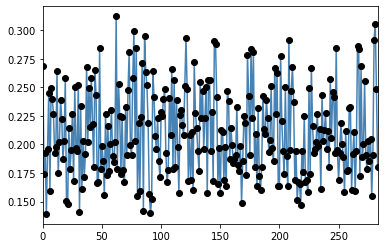

In [136]:
pd.Series(y_hat.tolist()).plot(color='steelblue')
pd.Series(y_hat.tolist()).plot(marker="o", linewidth=0, color='black')